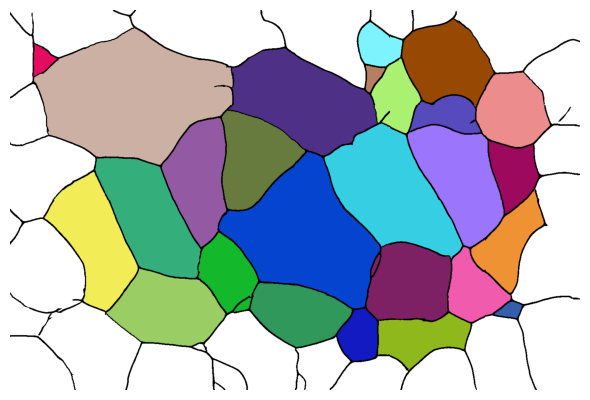

Number of complete connected components: 26
Average area of complete regions: 36019.0


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# 加载图像
image_path = r"C:\Users\Administrator\Desktop\processed\2.png"

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 进行连通域分析
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

# 设置面积阈值
min_area = 1000

# 获取图像尺寸
height, width = img.shape

# 判断连通域是否为完整的（不接触边界）
def is_complete_region(stat, height, width):
    x, y, w, h = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT]
    return x > 0 and y > 0 and (x + w) < width and (y + h) < height

# 存储新的连通域标签
new_labels = np.copy(labels)

# 归并小连通域到最近的大连通域
for label in range(1, num_labels):  # 忽略背景（label = 0）
    area = stats[label, cv2.CC_STAT_AREA]
    if area < min_area:
        # 小连通域的质心
        small_centroid = centroids[label]
        closest_label = -1
        min_dist = float('inf')

        # 找到最近的大连通域
        for other_label in range(1, num_labels):
            if other_label != label and stats[other_label, cv2.CC_STAT_AREA] >= min_area:
                dist = distance.euclidean(small_centroid, centroids[other_label])
                if dist < min_dist:
                    min_dist = dist
                    closest_label = other_label

        # 将小连通域合并到最近的大连通域
        if closest_label != -1:
            new_labels[labels == label] = closest_label
            stats[closest_label, cv2.CC_STAT_AREA] += area  # 更新大连通域的面积

# 统计完整连通域
complete_regions = []
for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    if area >= min_area and is_complete_region(stats[label], height, width):
        complete_regions.append((label, area))

# 计算完整连通域的平均面积
if complete_regions:
    average_area = np.mean([region[1] for region in complete_regions])
else:
    average_area = 0

output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # 将原始灰度图转换为RGB
colors = np.random.randint(0, 255, size=(num_labels, 3))

# 只对完整连通域进行着色
for label, _ in complete_regions:
    mask = new_labels == label
    output_img[mask] = colors[label]

# 显示结果
plt.figure(figsize=(6, 6))
plt.imshow(output_img)
plt.axis("off")
plt.tight_layout()
plt.show()

print("Number of complete connected components:", len(complete_regions))
print("Average area of complete regions:", average_area)
#8.620689654093427

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import math

def calculate_grain_parameters(image_path, scale_factor):
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    # 二值化
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # 识别连通组件
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    
    # 排除背景（标签0）
    grain_areas = [stats[i, cv2.CC_STAT_AREA] for i in range(1, num_labels)]
    if len(grain_areas) == 0:
        print(f"警告：图片 {image_path} 未检测到任何晶粒")
        return None
    
    # 计算平均像素面积
    total_area = sum(grain_areas)
    num_grains = len(grain_areas)
    average_pixel_area = total_area / num_grains
    
    # 转换为实际面积（单位：mm²）
    average_actual_area = average_pixel_area * (scale_factor ** 2)
    
    # 计算 G 值
    G = -3.288 - 6.643856 * np.log10(average_actual_area)
    
    return G

# 定义比例尺（示例值，单位：mm/像素）
scale_factor = 0.0013

# 读取Excel数据
df = pd.read_excel(r"C:\Users\Administrator\Desktop\paper\predict.xlsx")
adjusted_grain_sizes = df['Adjusted_Grain_Size'].values

# 处理所有图片
image_folder = r"C:\Users\Administrator\Desktop\processed"
calculated_grain_sizes = []
valid_adjusted_sizes = []
processed_files = []

for filename, adj_size in zip(sorted(os.listdir(image_folder)), adjusted_grain_sizes):
    if filename.endswith('.png'):
        image_path = os.path.join(image_folder, filename)
        grain_size = calculate_grain_parameters(image_path, scale_factor)
        if grain_size is not None:
            calculated_grain_sizes.append(grain_size)
            valid_adjusted_sizes.append(adj_size)
            processed_files.append(filename)

# 创建结果DataFrame
results_df = pd.DataFrame({
    'filename': processed_files,
    'calculated_grain_size': calculated_grain_sizes,
    'Adjusted_Grain_Size': valid_adjusted_sizes
})

# 计算误差指标
results_df['absolute_error'] = abs(results_df['calculated_grain_size'] - results_df['Adjusted_Grain_Size'])
results_df['relative_error'] = abs(results_df['calculated_grain_size'] - results_df['Adjusted_Grain_Size']) / results_df['calculated_grain_size'] * 100

# 计算统计指标
mse = np.mean((results_df['calculated_grain_size'] - a - results_df['Adjusted_Grain_Size']) ** 2)
rmse = np.sqrt(mse)
mae = results_df['absolute_error'].mean()
mape = results_df['relative_error'].mean()

# 输出统计结果
print(f"\n成功处理的图片数量: {len(calculated_grain_sizes)}")
print("\n误差统计：")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"平均相对误差百分比 (MAPE): {mape:.2f}%")

# 输出误差最大和最小的情况
print("\n相对误差最大的5行：")
print(results_df.nlargest(5, 'relative_error')[['filename', 'calculated_grain_size', 'Adjusted_Grain_Size', 'absolute_error', 'relative_error']])

print("\n相对误差最小的5行：")
print(results_df.nsmallest(5, 'relative_error')[['filename', 'calculated_grain_size', 'Adjusted_Grain_Size', 'absolute_error', 'relative_error']])

# 误差分布统计
print("\n相对误差分布：")
error_ranges = [0, 1, 5, 10, 20, float('inf')]
error_labels = ['0-1%', '1-5%', '5-10%', '10-20%', '>20%']
error_dist = pd.cut(results_df['relative_error'], bins=error_ranges, labels=error_labels)
error_stats = error_dist.value_counts().sort_index()
print(error_stats)
print(f"\n相对误差在5%以内的数据比例: {(error_dist.isin(['0-1%', '1-5%']).mean() * 100):.2f}%")


成功处理的图片数量: 40

误差统计：
均方误差 (MSE): 0.2549
均方根误差 (RMSE): 0.5048
平均绝对误差 (MAE): 0.4075
平均相对误差百分比 (MAPE): 8.28%

相对误差最大的5行：
   filename  calculated_grain_size  Adjusted_Grain_Size  absolute_error  \
22   29.png               3.902149                 5.22        1.317851   
24   30.png               4.079922                 5.12        1.040078   
10   18.png               4.414764                 5.22        0.805236   
20   27.png               4.490307                 5.22        0.729693   
12    2.png               5.774926                 4.86        0.914926   

    relative_error  
22       33.772452  
24       25.492586  
10       18.239615  
20       16.250406  
12       15.843075  

相对误差最小的5行：
   filename  calculated_grain_size  Adjusted_Grain_Size  absolute_error  \
35    5.png               5.410664                 5.37        0.040664   
3    11.png               5.420784                 5.37        0.050784   
2    10.png               5.179416                 5.12        0.05

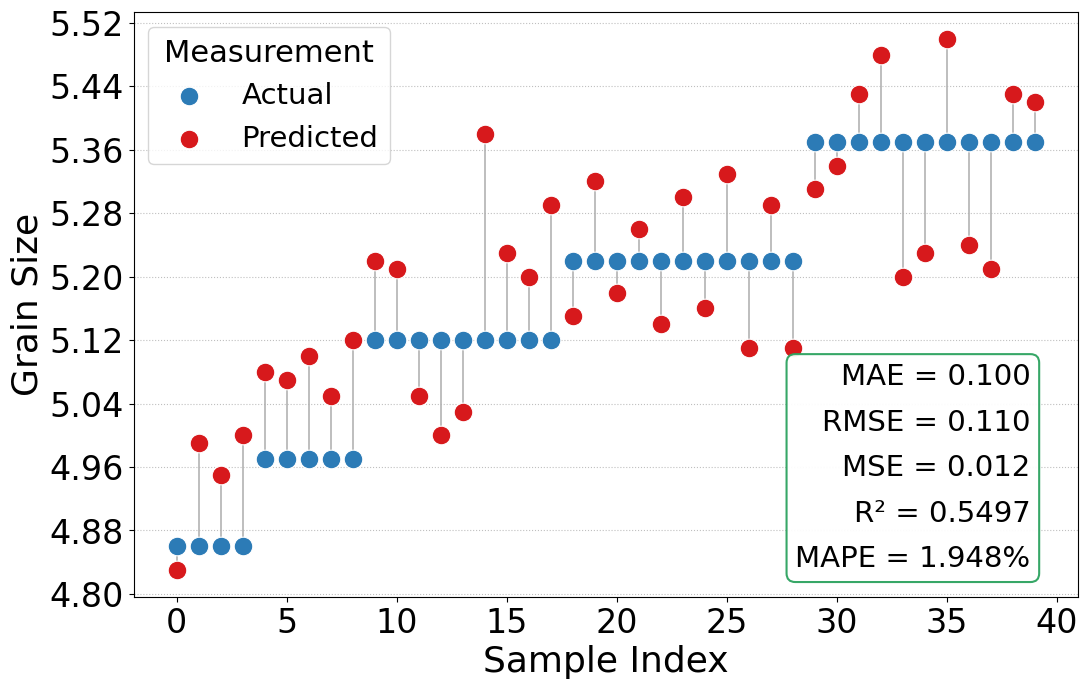

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_excel(r"C:\Users\Administrator\Desktop\paper\predict.xlsx")
df_sorted = df.sort_values('Adjusted_Grain_Size').reset_index(drop=True)

# 计算所有评估指标
actual = df_sorted['Adjusted_Grain_Size'].values
predicted = df_sorted['calculated_grain_size'].values

# 处理零值避免除零错误（MAPE计算需要）
non_zero_mask = actual != 0
actual_non_zero = actual[non_zero_mask]
predicted_non_zero = predicted[non_zero_mask]

# 计算指标
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)
mape = np.mean(np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero)) * 100  # 百分比形式

# Create plot
plt.figure(figsize=(11, 7))
for i in range(len(df_sorted)):
    plt.plot([i, i], 
             [df_sorted.loc[i, 'Adjusted_Grain_Size'], df_sorted.loc[i, 'calculated_grain_size']], 
             color='grey', linewidth=1.2, alpha=0.6, zorder=1)
sns.scatterplot(x=df_sorted.index, y='Adjusted_Grain_Size', data=df_sorted, 
                label='Actual', color='#2c7bb6', s=180, edgecolor='w', linewidth=0.8, zorder=2)
sns.scatterplot(x=df_sorted.index, y='calculated_grain_size', data=df_sorted, 
                label='Predicted', color='#d7191c', s=180, edgecolor='w', linewidth=0.8, zorder=2)

# 坐标轴设置
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# 自定义样式
plt.xlabel('Sample Index', fontsize=26)
plt.ylabel('Grain Size', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(title='Measurement', title_fontsize=22, fontsize=21)
plt.grid(axis='y', linestyle=':', alpha=0.8)

# 整合所有指标（优化排版）
metrics_text = (
    f'MAE = {mae:.3f}\n'
    f'RMSE = {rmse:.3f}\n'
    f'MSE = {mse:.3f}\n'  # 科学计数法
    f'R² = {r2:.4f}\n'
    f'MAPE = {mape:.3f}%'  # 百分比格式
)

plt.text(0.95, 0.40, metrics_text,  # 调整到30%高度位置
         transform=ax.transAxes,
         ha='right', 
         va='top',
         fontsize=21,  # 稍小字号
         linespacing=1.8,  # 增加行间距
         bbox=dict(boxstyle='round', 
                   facecolor='white', 
                   alpha=0.95,
                   edgecolor='#2ca25f',
                   linewidth=1.5,
                   ))  # 减少内边距

plt.tight_layout()
plt.show()


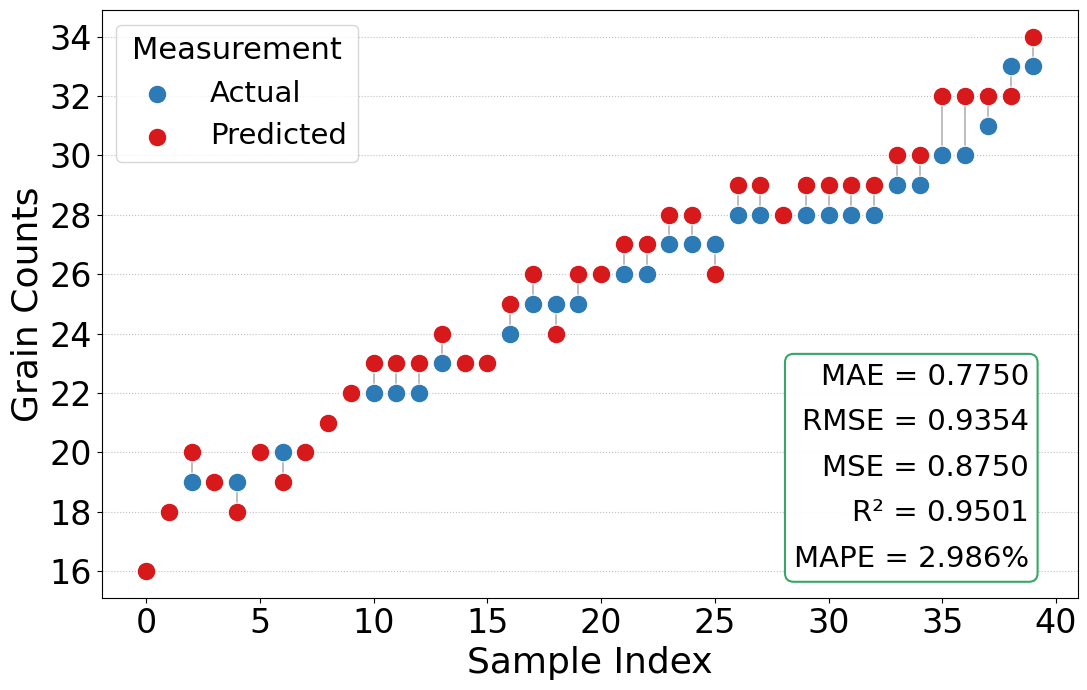

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_excel(r"C:\Users\Administrator\Desktop\paper\predict.xlsx")
df_sorted = df.sort_values('grains_truth').reset_index(drop=True)

# 计算所有评估指标
actual = df_sorted['grains_truth'].values
predicted = df_sorted['predict_grains'].values

# 处理零值避免除零错误（MAPE计算需要）
non_zero_mask = actual != 0
actual_non_zero = actual[non_zero_mask]
predicted_non_zero = predicted[non_zero_mask]

# 计算指标
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)
mape = np.mean(np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero)) * 100  # 百分比形式

# Create plot
plt.figure(figsize=(11, 7))
for i in range(len(df_sorted)):
    plt.plot([i, i], 
             [df_sorted.loc[i, 'grains_truth'], df_sorted.loc[i, 'predict_grains']], 
             color='grey', linewidth=1.2, alpha=0.6, zorder=1)
sns.scatterplot(x=df_sorted.index, y='grains_truth', data=df_sorted, 
                label='Actual', color='#2c7bb6', s=180, edgecolor='w', linewidth=0.8, zorder=2)
sns.scatterplot(x=df_sorted.index, y='predict_grains', data=df_sorted, 
                label='Predicted', color='#d7191c', s=180, edgecolor='w', linewidth=0.8, zorder=2)

# 坐标轴设置
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# 自定义样式
plt.xlabel('Sample Index', fontsize=26)
plt.ylabel('Grain Counts', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(title='Measurement', title_fontsize=22, fontsize=21)
plt.grid(axis='y', linestyle=':', alpha=0.8)

# 整合所有指标（优化排版）
metrics_text = (
    f'MAE = {mae:.4f}\n'
    f'RMSE = {rmse:.4f}\n'
    f'MSE = {mse:.4f}\n'  # 科学计数法
    f'R² = {r2:.4f}\n'
    f'MAPE = {mape:.3f}%'  # 百分比格式
)

plt.text(0.95, 0.40, metrics_text,  # 调整到30%高度位置
         transform=ax.transAxes,
         ha='right', 
         va='top',
         fontsize=21,  # 稍小字号
         linespacing=1.8,  # 增加行间距
         bbox=dict(boxstyle='round', 
                   facecolor='white', 
                   alpha=0.95,
                   edgecolor='#2ca25f',
                   linewidth=1.5,
                   ))  # 减少内边距

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
from openpyxl import load_workbook

# 定义评估指标计算函数
def calculate_metrics(truth, predict):
    truth = np.array(truth)
    predict = np.array(predict)
    
    # 计算准确率（预测完全正确的比例）
    accuracy = np.mean(truth == predict)
    
    # 计算MSE
    mse = np.mean((truth - predict) ** 2)
    
    # 计算RMSE
    rmse = np.sqrt(mse)
    
    # 计算MAE
    mae = np.mean(np.abs(truth - predict))
    
    # 计算MAPE（排除真实值为0的情况）
    mask = truth != 0
    mape = np.mean(np.abs((truth[mask] - predict[mask]) / truth[mask])) * 100
    
    return {
        "accuracy": accuracy,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }

# 文件路径配置
excel_path = r"C:\Users\Administrator\Desktop\paper\predict.xlsx"

# 加载工作簿
wb = load_workbook(excel_path)
ws = wb.active

# 获取列索引
headers = [cell.value for cell in ws[1]]
truth_col = headers.index("Adjusted_Grain_Size") + 1
predict_col = headers.index("NN") + 1

# 读取数据
truth_values = []
predict_values = []

for row in ws.iter_rows(min_row=2):  # 假设数据从第二行开始
    truth_values.append(row[truth_col-1].value)
    predict_values.append(row[predict_col-1].value)

# 转换数据类型并过滤无效值
valid_pairs = []
for t, p in zip(truth_values, predict_values):
    try:
        valid_pairs.append((float(t), float(p)))
    except (TypeError, ValueError):
        continue

truth, predict = zip(*valid_pairs)

# 计算指标
metrics = calculate_metrics(truth, predict)

# 打印结果
print("评估结果：")
print(f"准确率: {metrics['accuracy']:.4%}")
print(f"MSE: {metrics['MSE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")
print(f"MAPE: {metrics['MAPE']:.2f}%")


评估结果：
准确率: 0.0000%
MSE: 1.0675
RMSE: 1.0332
MAE: 0.7997
MAPE: 15.54%
